#Sentiment Analysis - Airline Passenger Satisfaction


-----



<img src="https://simplonline.co/_next/image?url=https%3A%2F%2Fsimplonline-v3-prod.s3.eu-west-3.amazonaws.com%2Fmedia%2Fimage%2Fjpg%2F64814-shutterstock-1073953772-642497423efc3496249445.jpg&w=1280&q=75" width="500"/>

## Objectifs
A partir d'une enquête de satisfaction menée sur un ensemble de 130 000 passagers, vous devez mettre en oeuvre une démarche de machine learning : 
- pour comprendre quelles sont les informations qui influent sur la satisfaction / insatisfaction d'un passager
- pour prédire la satisfaction / insatisfaction d'un passager

## EDA (Exploratory Data Analysis) sur le jeu de données

In [5]:
# # Mount drive
# from google.colab import drive
# drive.mount('/content/drive/')

## 1.Le jeu de données
Le jeu de données est disponible ci-dessous.  
Il concerne la satisfaction client selon différentes caractéristiques :
* la cible à prédire est la colonne `Satisfaction`
* les features (numériques et catégorielles) sont toutes les autres colonnes :
  - `Age`:L'age des passagers
  -  `Gender`: Le genre des passagers (Femme, Homme)
  -  `Type of Travel`: Le but du voyage des passagers (Voyage personnel, Voyage d'affaires)
  -  `Class`: La classe de voyage dans l'avion des passagers (Affaires, Économique, Économique Plus)
  -  `Customer Type`: Le type de client (Client fidèle, client infidèle)
  -  `Flight distance`: La distance de vol de ce voyage
  -  `Inflight wifi service`: Le niveau de satisfaction du service wifi à bord (0: Non applicable; 1-5)
  -  `Ease of Online booking`: Le niveau de satisfaction de la réservation en ligne
  -  `Inflight service`: Le niveau de satisfaction du service à bord
  -  `Online boarding`: Le niveau de satisfaction de l'embarquement en ligne
  -  `Inflight entertainment`: Le niveau de satisfaction du divertissement à bord
  -  `Food and drink`: Le niveau de satisfaction de la nourriture et de la boisson
  -  `Seat comfort`: Le niveau de satisfaction du confort des sièges
  -  `On-board service`: Le niveau de satisfaction du service à bord
  -  `Leg room service`: Le niveau de satisfaction de l'espace pour les jambes
  -  `Departure/Arrival time convenient`: Le niveau de satisfaction de la convenance de l'heure de départ/arrivée
  -  `Baggage handling`: Le niveau de satisfaction de la gestion des bagages
  -  `Gate location`: Le niveau de satisfaction de l'emplacement de la porte
  -  `Cleanliness`: Le niveau de satisfaction de la propreté
  -  `Check-in service`: Le niveau de satisfaction du service d'enregistrement
  -  `Departure Delay in Minutes`: Les minutes de retard au départ
  -  `Arrival Delay in Minutes`: Les minutes de retard à l'arrivée
  -  `Flight cancelled`: Si le vol a été annulé ou non (Oui, Non)
  -  `Flight time in minutes`: Les minutes de la durée de vol

## 2.Les librairies


In [6]:
!pip install numpy==1.23
!pip install dython

In [7]:
# Import et traitement des données
import pandas as pd
import numpy as np
import pickle

#correlation
from dython.nominal import associations
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# Graphiques
import seaborn as sns ; sns.set()
import matplotlib.pyplot as plt

# Machine learning - Preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler, StandardScaler #MinMaxScaler, 
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer

# Machine learning - Automatisation
from sklearn.pipeline import Pipeline
from sklearn import set_config

# Machine learning - Modèle d'apprentissage supervisé
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.decomposition import PCA

# Machine learning - Modèle selection
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, HalvingGridSearchCV

# Machine learning - Métriques d'erreur
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score, fbeta_score, ConfusionMatrixDisplay, roc_curve, auc
from scikitplot.metrics import plot_roc_curve

In [8]:
# read csv
url = "https://raw.githubusercontent.com/remijul/dataset/master/Airline%20Passenger%20Satisfaction.csv"
df = pd.read_csv(url, encoding='utf-8', sep=';')
df.drop(['id'], axis=1, inplace=True)
df.columns = df.columns.str.replace(" ", "_")
df.columns = df.columns.str.replace("-", "_")
df.columns = df.columns.str.replace("/", "_")
df.head()


,Satisfaction,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Seat_comfort,Departure_Arrival_time_convenient,Food_and_drink,...,Online_support,Ease_of_Online_booking,On_board_service,Leg_room_service,Baggage_handling,Checkin_service,Cleanliness,Online_boarding,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


## 3.Analyse de données exploratoire (EDA)

### 3.1 Description du dataset

In [9]:
# Dimmension du jeu de données
df.shape

(129880, 23)

In [10]:
# Nom et types
df.dtypes


Satisfaction                          object
Gender                                object
Customer_Type                         object
Age                                    int64
Type_of_Travel                        object
Class                                 object
Flight_Distance                        int64
Seat_comfort                           int64
Departure_Arrival_time_convenient      int64
Food_and_drink                         int64
Gate_location                          int64
Inflight_wifi_service                  int64
Inflight_entertainment                 int64
Online_support                         int64
Ease_of_Online_booking                 int64
On_board_service                       int64
Leg_room_service                       int64
Baggage_handling                       int64
Checkin_service                        int64
Cleanliness                            int64
Online_boarding                        int64
Departure_Delay_in_Minutes             int64
Arrival_De

In [11]:
# Infos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  object 
 2   Customer_Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type_of_Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight_Distance                    129880 non-null  int64  
 7   Seat_comfort                       129880 non-null  int64  
 8   Departure_Arrival_time_convenient  129880 non-null  int64  
 9   Food_and_drink                     129880 non-null  int64  
 10  Gate_location                      129880 non-null  int64  
 11  Inflight_wifi_service              1298

###Données manquantes?


In [12]:
df.isna().sum()

Satisfaction                           0
Gender                                 0
Customer_Type                          0
Age                                    0
Type_of_Travel                         0
Class                                  0
Flight_Distance                        0
Seat_comfort                           0
Departure_Arrival_time_convenient      0
Food_and_drink                         0
Gate_location                          0
Inflight_wifi_service                  0
Inflight_entertainment                 0
Online_support                         0
Ease_of_Online_booking                 0
On_board_service                       0
Leg_room_service                       0
Baggage_handling                       0
Checkin_service                        0
Cleanliness                            0
Online_boarding                        0
Departure_Delay_in_Minutes             0
Arrival_Delay_in_Minutes             393
dtype: int64

### 3.2 Analyse univariée 
Description statistique des données.


In [13]:
df.describe(include='all')

,Satisfaction,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Seat_comfort,Departure_Arrival_time_convenient,Food_and_drink,...,Online_support,Ease_of_Online_booking,On_board_service,Leg_room_service,Baggage_handling,Checkin_service,Cleanliness,Online_boarding,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes
count,129880,129880,129880,129880.000000,129880,129880,129880.000000,129880.000000,129880.000000,129880.000000,...,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
unique,2,2,2,NaN,2,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,satisfied,Female,Loyal Customer,NaN,Business travel,Business,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,71087,65899,106100,NaN,89693,62160,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,39.427957,NaN,NaN,1981.409055,2.838597,2.990645,2.851994,...,3.519703,3.472105,3.465075,3.485902,3.695673,3.340807,3.705759,3.352587,14.713713,15.091129
std,NaN,NaN,NaN,15.119360,NaN,NaN,1027.115606,1.392983,1.527224,1.443729,...,1.306511,1.305560,1.270836,1.292226,1.156483,1.260582,1.151774,1.298715,38.071126,38.465650
min,NaN,NaN,NaN,7.000000,NaN,NaN,50.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,27.000000,NaN,NaN,1359.000000,2.000000,2.000000,2.000000,...,3.000000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,NaN,NaN,NaN,40.000000,NaN,NaN,1925.000000,3.000000,3.000000,3.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000,0.000000,0.000000
75%,NaN,NaN,NaN,51.000000,NaN,NaN,2544.000000,4.000000,4.000000,4.000000,...,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000


### 3.3 Analyse bivariée - Variables numériques

Distribution de la target en fonction des variables numériques.

In [14]:
#df_eda
df_eda = df.replace(['Male', 'Female'],[0, 1])
df_eda['Arrival_Delay_in_Minutes'] = df['Arrival_Delay_in_Minutes'].fillna(df['Departure_Delay_in_Minutes'])
# df_eda['Arrival Delay in Minutes'] = df_eda['Arrival Delay in Minutes'].astype('int64')
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129880 entries, 0 to 129879
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Satisfaction                       129880 non-null  object 
 1   Gender                             129880 non-null  int64  
 2   Customer_Type                      129880 non-null  object 
 3   Age                                129880 non-null  int64  
 4   Type_of_Travel                     129880 non-null  object 
 5   Class                              129880 non-null  object 
 6   Flight_Distance                    129880 non-null  int64  
 7   Seat_comfort                       129880 non-null  int64  
 8   Departure_Arrival_time_convenient  129880 non-null  int64  
 9   Food_and_drink                     129880 non-null  int64  
 10  Gate_location                      129880 non-null  int64  
 11  Inflight_wifi_service              1298

In [15]:
# create a dataframe
dataframe = pd.DataFrame(df_eda, columns = ['Satisfaction',	'Gender',	'Customer', 'Type_Age','Departure_Delay_in_Minutes',	'Arrival_Delay_in_Minutes' ])

  
# selecting rows based on condition
rslt_df = dataframe[dataframe['Arrival_Delay_in_Minutes'].isna() ]
rslt_df

,Satisfaction,Gender,Customer,Type_Age,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes


C:\Users\tarik\AppData\Local\Temp\ipykernel_2800\2291641827.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(2,2,1)


<AxesSubplot: xlabel='Type_of_Travel', ylabel='Count'>

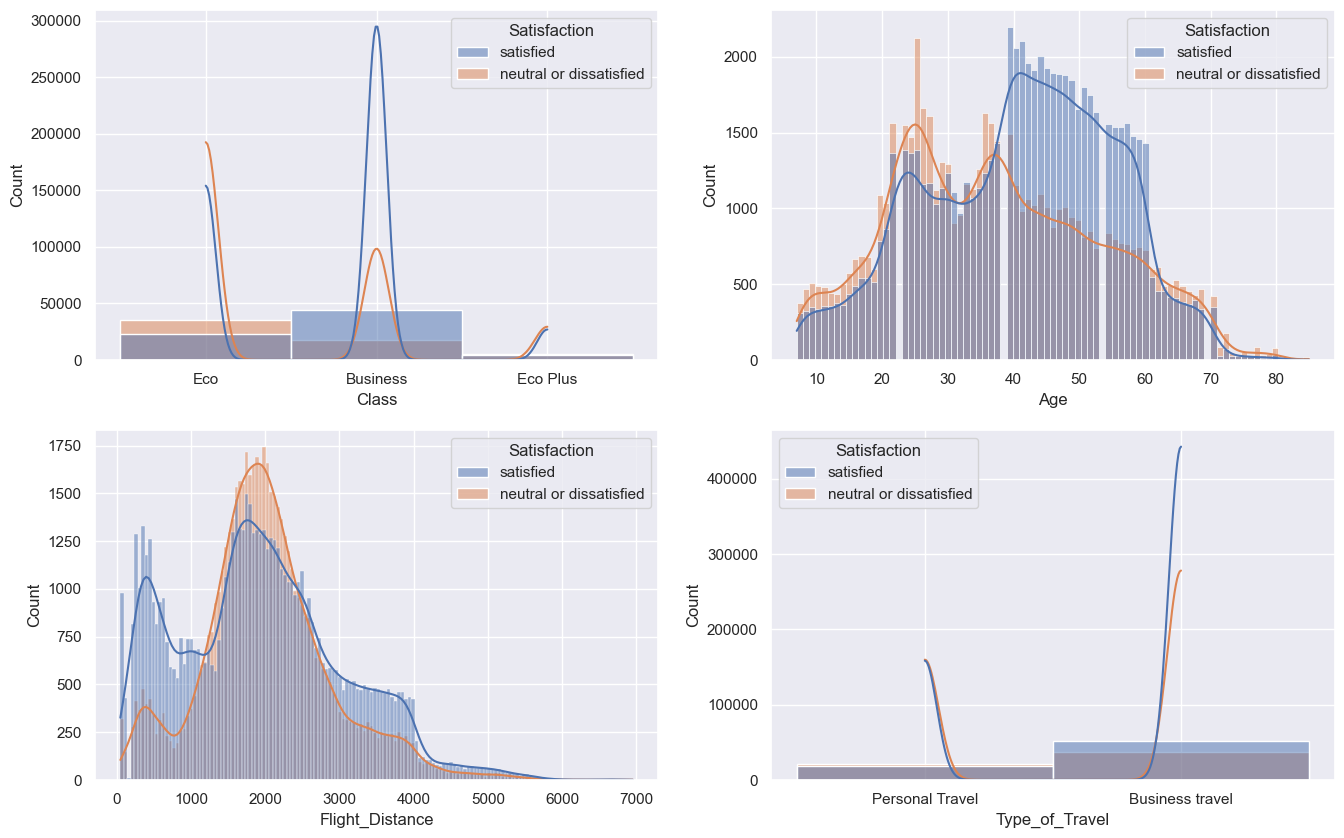

In [16]:
fig, axs = plt.subplots(figsize=(16, 10))

# Plot variable 1
ax1 = plt.subplot(2,2,1)
sns.histplot(data=df_eda, x="Class", hue="Satisfaction", kde=True)

# Plot variable 2
ax1 = plt.subplot(2,2,2)
sns.histplot(data=df_eda, x="Age", hue="Satisfaction", kde=True)

# Plot variable 3
ax1 = plt.subplot(2,2,3)
sns.histplot(data=df_eda, x="Flight_Distance", hue="Satisfaction", kde=True)

# Plot variable 4
ax1 = plt.subplot(2,2,4)
sns.histplot(data=df_eda, x="Type_of_Travel", hue="Satisfaction", kde=True)




### 3.4 Data correlation

In [17]:
# Identification des colonnes categorielle avec dython comme le select_dtypes(include=['object']) de pandas
from dython.nominal import identify_nominal_columns
categorical_features=identify_nominal_columns(df_eda)
categorical_features

['Satisfaction', 'Customer_Type', 'Type_of_Travel', 'Class']

In [18]:
#option de la fonction association qui retourne la matrice de correlation corr et le graphique de cette dernière ax (matplotlib)
#   associations(dataset, nominal_columns='auto', numerical_columns=None, mark_columns=False, nom_nom_assoc='cramer', num_num_assoc='pearson', bias_correction=True, nan_strategy=_REPLACE, nan_replace_value=_DEFAULT_REPLACE_VALUE, ax=None, figsize=None, annot=True, fmt='.2f', cmap=None, sv_color='silver', cbar=True, vmax=1.0, vmin=None, plot=True, compute_only=False, clustering=False, title=None, filename=None)

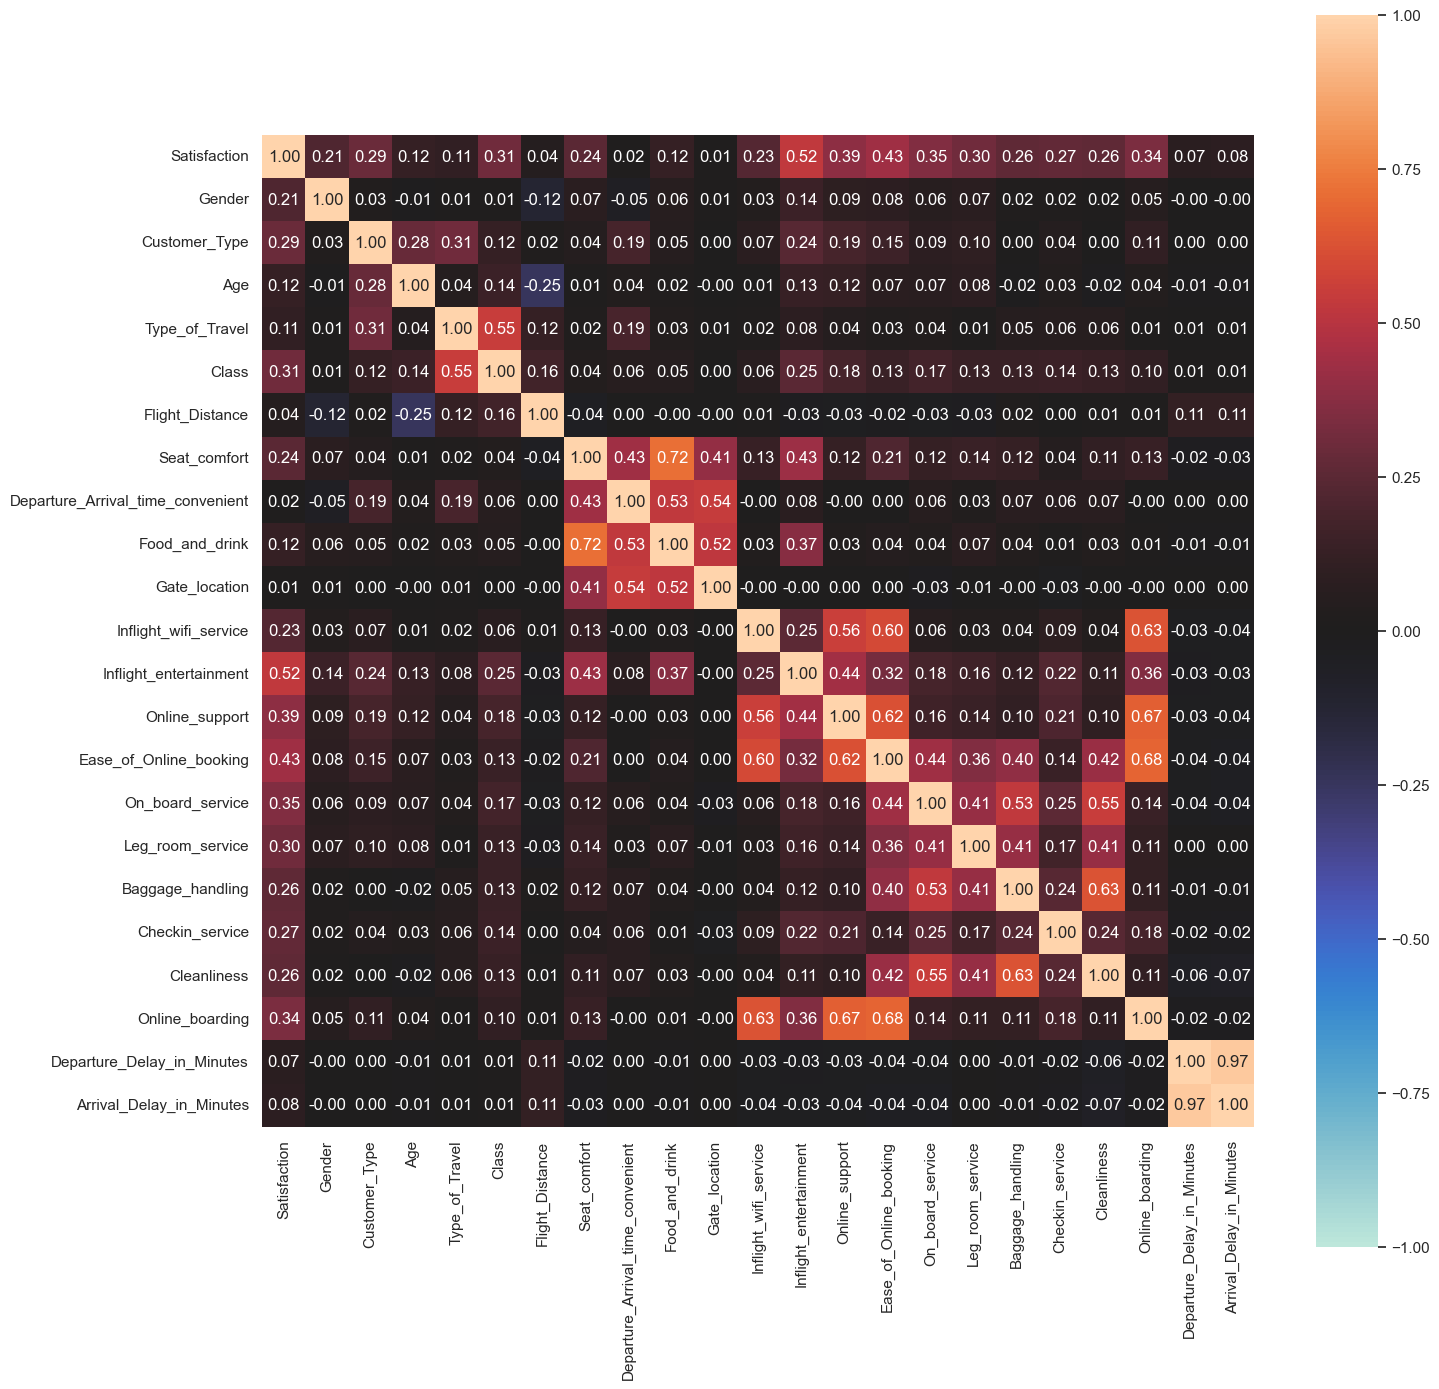

In [19]:
complete_correlation= associations(df_eda,  filename= 'complete_correlation.png', figsize=(16,16))

In [20]:
# convert categorical variables to numerical variables
# df_eda = pd.get_dummies(df_eda)

# create correlation matrix
# corr_matrix = df_eda.corr()
corr_matrix = complete_correlation['corr']
# # select only columns with correlation > 0.3 with the target variable 'Satisfaction'
# corr_cols = corr_matrix.loc[corr_matrix['Satisfaction_satisfied'] > 0.25, 'Satisfaction_satisfied'].sort_values(ascending=False)
corr_cols = corr_matrix.loc[corr_matrix['Satisfaction'] > 0.22, 'Satisfaction'].sort_values(ascending=False)
# print the resulting correlation matrix
corr_cols

Satisfaction              1.000000
Inflight_entertainment    0.523496
Ease_of_Online_booking    0.431772
Online_support            0.390143
On_board_service          0.352047
Online_boarding           0.338147
Class                     0.312330
Leg_room_service          0.304928
Customer_Type             0.292560
Checkin_service           0.266179
Baggage_handling          0.260347
Cleanliness               0.259330
Seat_comfort              0.242384
Inflight_wifi_service     0.227062
Name: Satisfaction, dtype: float64

##Anova

In [21]:
from scipy.stats import f_oneway

def anova_test(df, target_col):
    """
    Performs ANOVA test between each numerical feature in the dataframe and the target variable
    specified by target_col and returns a new dataframe containing the F-score and p-value
    for each test.
    
    Args:
    df (pandas.DataFrame): the input dataframe
    target_col (str): the name of the target column in the dataframe
    
    Returns:
    pandas.DataFrame: a dataframe containing the F-score and p-value for each ANOVA test.
    """
    p_values = []
    f_scores = []
    columns = []
    
    # Perform ANOVA test for each numerical column in the dataframe
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        if col != target_col:
            category_groups = [df[df[target_col] == category][col] for category in df[target_col].unique()]
            f, p = f_oneway(*category_groups)
            p_values.append(p)
            f_scores.append(f)
            columns.append(col)
    
    # Create a new dataframe with the results
    results_df = pd.DataFrame({'Feature': columns, 'F-score': f_scores, 'p-value': p_values})
    return results_df

In [22]:
df.head(1)

,Satisfaction,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Seat_comfort,Departure_Arrival_time_convenient,Food_and_drink,...,Online_support,Ease_of_Online_booking,On_board_service,Leg_room_service,Baggage_handling,Checkin_service,Cleanliness,Online_boarding,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0


In [23]:
anova_df = anova_test(df_eda, "Satisfaction")
anova_df

,Feature,F-score,p-value
0,Gender,6126.187829,0.000000e+00
1,Age,1833.056185,0.000000e+00
2,Flight_Distance,200.131470,2.113119e-45
3,Seat_comfort,8106.626158,0.000000e+00
4,Departure_Arrival_time_convenient,31.237053,2.288219e-08
5,Food_and_drink,1919.346091,0.000000e+00
6,Gate_location,18.926652,1.359450e-05
7,Inflight_wifi_service,7060.130966,0.000000e+00
8,Inflight_entertainment,49029.186435,0.000000e+00
9,Online_support,23318.295343,0.000000e+00


In [24]:
sorted_features = anova_df.sort_values(by=['F-score'], ascending=False)['Feature'].tolist()
sorted_features

['Inflight_entertainment',
 'Ease_of_Online_booking',
 'Online_support',
 'On_board_service',
 'Online_boarding',
 'Leg_room_service',
 'Checkin_service',
 'Baggage_handling',
 'Cleanliness',
 'Seat_comfort',
 'Inflight_wifi_service',
 'Gender',
 'Food_and_drink',
 'Age',
 'Arrival_Delay_in_Minutes',
 'Departure_Delay_in_Minutes',
 'Flight_Distance',
 'Departure_Arrival_time_convenient',
 'Gate_location']

###On observe que:
les features les plus corrélées avec la satisfaction client sont les services à bord avec:
 - divertissement à bord,
 - la class,
 - l'espace pour les jambes(normale ^^)
 - baggages,
 - enregistrement,
 - propreté

et les services en lignes:
 - le support en ligne,
 - Online_boarding


<AxesSubplot: >

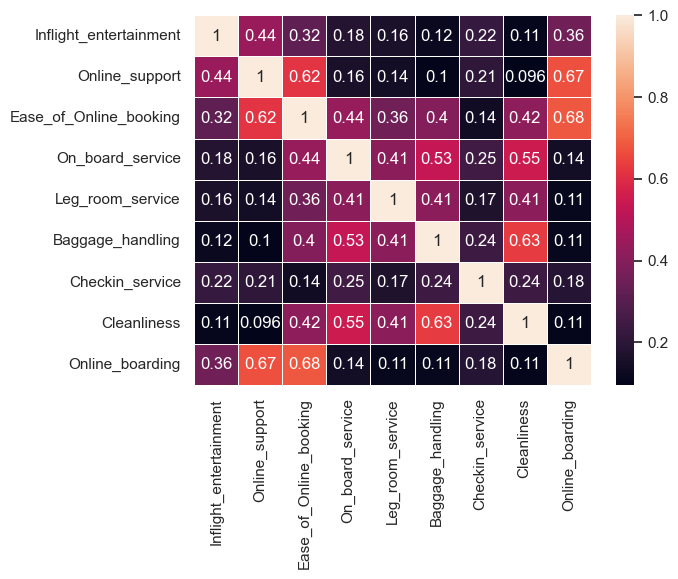

In [25]:
#matrice correlation
sns.heatmap(df_eda[['Inflight_entertainment', 'Online_support', 'Ease_of_Online_booking',
                    'On_board_service', 'Leg_room_service', 'Baggage_handling', 'Checkin_service',
                    'Cleanliness', 'Online_boarding']].corr(), annot=True, linewidths=0.5)

### Ce que j'observe:
 - Une correlation entre les variables de même types les services en ligne sont fortement dépendants de Online_support ce qui est logique.
 - Je ne comprends cependants pas la corrélation entre `Inflight_entertainment` et `Online_support`

Les features 

## 4.Preprocessing

### 4.1 Preprocessing sur la cible

Sélection de la variable cible (target) `Satisfaction`.

In [26]:
y = df['Satisfaction']

### 4.2 Preprocessing sur les features

Features preprocessing

In [27]:
X = df.drop(columns='Satisfaction')
X.head()

,Gender,Customer_Type,Age,Type_of_Travel,Class,Flight_Distance,Seat_comfort,Departure_Arrival_time_convenient,Food_and_drink,Gate_location,...,Online_support,Ease_of_Online_booking,On_board_service,Leg_room_service,Baggage_handling,Checkin_service,Cleanliness,Online_boarding,Departure_Delay_in_Minutes,Arrival_Delay_in_Minutes
0,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,2,...,2,3,3,0,3,5,3,2,0,0.0
1,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,3,...,2,3,4,4,4,2,3,2,310,305.0
2,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,3,...,2,2,3,3,4,4,4,2,0,0.0
3,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,3,...,3,1,1,0,1,4,1,3,0,0.0
4,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,3,...,4,2,2,0,2,4,2,5,0,0.0


#### 4.2.1 Variables catégorielles

Selection des variables categorielles.

In [28]:
column_cat = X.select_dtypes(include=['object']).columns
column_cat

Index(['Gender', 'Customer_Type', 'Type_of_Travel', 'Class'], dtype='object')

Déclaration de la méthode de preprocessing sur les variables catégorielles.

In [29]:
transfo_cat = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output = False))
])

#### 4.2.2 Variables numériques

Selection des variables numériques.

In [30]:
column_num = X.select_dtypes(exclude=['object']).columns
column_num

Index(['Age', 'Flight_Distance', 'Seat_comfort',
       'Departure_Arrival_time_convenient', 'Food_and_drink', 'Gate_location',
       'Inflight_wifi_service', 'Inflight_entertainment', 'Online_support',
       'Ease_of_Online_booking', 'On_board_service', 'Leg_room_service',
       'Baggage_handling', 'Checkin_service', 'Cleanliness', 'Online_boarding',
       'Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes'],
      dtype='object')

Déclaration de la méthode de preprocessing sur les variables numériques.

In [31]:
transfo_num = Pipeline(steps=[
    ('imputation', KNNImputer(n_neighbors=3, weights="uniform")),
    ('scaling', StandardScaler())
])

#### 4.2.3 Transformation des features

In [32]:
preparation = ColumnTransformer(
    transformers=[
        ('data_cat', transfo_cat , column_cat),
        ('data_num', transfo_num , column_num)
    ])

In [33]:
set_config(display="diagram")
preparation

ColumnTransformer(transformers=[('data_cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Gender', 'Customer_Type', 'Type_of_Travel', 'Class'], dtype='object')),
                                ('data_num',
                                 Pipeline(steps=[('imputation',
                                                  KNNImputer(n_neighbors=3)),
                                                 ('scaling',
                                                  StandardScaler())]),
                                 Index(['Age', 'Flight_Distance', 'Seat_comfort',
       'Departure_Arrival_time_convenient', 'Food_and_drink', 'Gate_location',
       'Inflight_wifi_service', 'Inflight_entertainment', 'Online_support',
       'Ease_of_Online_booking', 'On_board_service', 'Leg_room_service',
       'Baggage_handling', 'Checkin_service', 'Cleanliness', 'Online_boarding',
       'Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes'],
      dtype='object'))])

### 4.3 Répartition `train-test-split` 

In [34]:
# Noter la présence du stratify sur la target pour mieux équilibrer les observation sur la target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)

## 5.Entrainement du modèle


### 5.1 Premier essai : `KNeighboursClassifier` pour voir un modèle sans optimisation.

In [35]:
clf = KNeighborsClassifier()

#### 5.1.1 Déclaration du modèle
Déclaration du modèle sans paramétrage.
Documentation [KNC()](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier).

#### 5.1.2 Intégration dans le pipeline
Intégration du modèle d'apprentissage dans le pipeline.

In [36]:
model = Pipeline(steps=[('preparation', preparation),
                        ('model', clf)])
model

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('data_cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Gender', 'Customer_Type', 'Type_of_Travel', 'Class'], dtype='object')),
                                                 ('data_num',
                                                  Pipeline(steps=[('imputation',
                                                                   KNNImputer(n_neighbors=3)),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  Index(['Age'...
       'Departure_Arrival_time_convenient', 'Food_and_drink', 'Gate_location',
       'Inflight_wifi_service', 'Inflight_entertainment', 'Online_support',
       'Ease_of_Online_booking', 'On_board_service', 'Leg_room_service',
       'Baggage_handling', 'Checkin_service', 'Cleanliness', 'Online_boarding',
       'Departure_Delay_in_Minutes', 'Arrival_Delay_in_Minutes'],
      dtype='object'))])),
                ('model', KNeighborsClassifier())])

#### 5.1.3 Apprentissage
Phase d'apprentissage du modèle.

In [37]:

cv = StratifiedKFold(n_splits=5)
# Fit the pipeline to the training data and evaluate it using cross-validation
model.fit(X_train, y_train)
scores = cross_val_score(model, X_train, y_train, cv=cv)

# Print the mean score and the standard deviation
print("Accuracy: %0.3f (+/- %0.3f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.922 (+/- 0.003)


#### 5.1.4 Prédictions
Utiliser du jeu de test pour réaliser les prédictions.

In [38]:
y_pred = model.predict(X_test)
y_pred

array(['satisfied', 'neutral or dissatisfied', 'neutral or dissatisfied',
       ..., 'satisfied', 'satisfied', 'satisfied'], dtype=object)

#### 5.1.5 Evaluation
Evaluation de la performance (`accuracy score`) du modèle.


In [39]:
score = accuracy_score(y_test, y_pred)
print(f"Performance du modèle {clf} - Accuracy score :", round(score, 5))

Performance du modèle KNeighborsClassifier() - Accuracy score : 0.92447


Matrice de confusion

In [40]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
conf_matrix

array([[11010,   749],
       [ 1213, 13004]], dtype=int64)

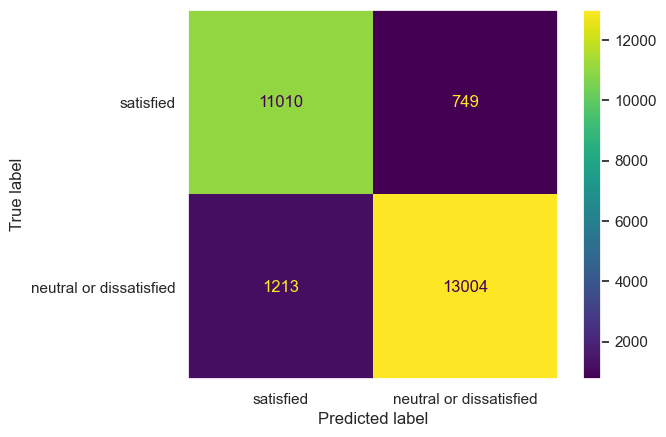

In [41]:
sns.set_style("dark")

cm_plot = ConfusionMatrixDisplay(conf_matrix,
                                display_labels=df['Satisfaction'].unique())

cm_plot.plot()

## 6.Comparaison de modèles

### 6.1 Construction d'une fonction `getClassifResults()`
Pour faciliter le processus complet d'entrainement et d'évaluation du modèle, nous allons créer ici une fonction qui fait l'intégralité du processus d'apprentissage supervisé et qui restitue les performances du modèle.  

La fonction `getClassifResults()` prend comme paramètres d'entrée :  
* `classifier` : le modèle de classification que nous souhaitons utiliser.
* `parameters` : la liste des hyper-paramètres et de leurs valeurs qui souhaitons étudier dans le processus `GridSearchCV`, au format dictionnaire.
* `data` : la dataframe sur laquelle nous souhaitons réaliser le processus d'apprentissage supervisé.

In [42]:
def getClassifResults(classifier, parameters, data):
    # PREPROCESSING
    # Target
    y = data['Satisfaction']
    # Features preprocessing
    X = data.drop(columns='Satisfaction')
  
    column_cat = X.select_dtypes(include=['object']).columns
    transfo_cat = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse = False))
    ])
  
    column_num = X.select_dtypes(exclude=['object']).columns
    transfo_num = Pipeline(steps=[
        ('imputation', KNNImputer(n_neighbors=3, weights="uniform")),
        ('scaling', StandardScaler())
    ])

    preparation = ColumnTransformer(
        transformers=[
            ('data_cat', transfo_cat , column_cat),
            ('data_num', transfo_num , column_num)
        ])

    # train-test-split  
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)  
    # Pipeline and Model
    model = Pipeline(steps=[('preparation', preparation),
                            ('model', classifier)])

    # Define the cross-validation strategy
    cv = StratifiedKFold(n_splits=5)

    # Gridsearch
    grid = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'f1_weighted', cv = cv, n_jobs =-1, verbose = 2)
  
    # Fit
    grid.fit(X_train, y_train)

    # Predict
    y_pred = grid.predict(X_test)
    y_train_pred = grid.predict(X_train)
    train_accu_score = accuracy_score(y_train, y_train_pred)
    test_f1_score = fbeta_score(y_test, y_pred, average='weighted', beta=0.5)
    test_accu_score = accuracy_score(y_test, y_pred)
    
    # Results
    classifier_results = []
    classifier_results.append(grid.cv_results_['mean_fit_time'].mean().round(4))
    classifier_results.append(grid.best_score_.round(4))
    classifier_results.append(train_accu_score.round(4))
    classifier_results.append(test_f1_score.round(4))
    classifier_results.append(test_accu_score.round(4))
    classifier_results.append(grid.best_params_)

    

    # Best model and best parameters
    best_model = grid.best_estimator_
    # save the model to disk
    filename = f'best_model_{str(classifier).replace("()","")}.pkl'
    pickle.dump(model, open(filename, 'wb'))
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix {classifier}')

    return classifier_results, best_model

### 6.2 Création d'un dictionnaire de model a tester

In [43]:
classifiers = {
    'KNeighborsClassifier': {'model__n_neighbors': range(1, 10, 2)},
    'RandomForestClassifier': {'model__n_estimators': range(50, 500, 50), 'model__criterion': ('gini', 'entropy')},
    'HistGradientBoostingClassifier': {'model__learning_rate': np.arange(start=0.1, stop=0.9, step=0.1), 'model__loss': ('auto', 'binary_crossentropy')}
}

#### Utilisation de la fonction getClassifResults et plot des matrices de confusion de chaque modèle

Fitting 5 folds for each of 5 candidates, totalling 25 fits


c:\Users\tarik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fitting 5 folds for each of 18 candidates, totalling 90 fits


c:\Users\tarik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\tarik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\tarik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_hist_gradient_boosting\gradient_boosting.py:1998: FutureWarning: The loss 'binary_crossentropy' was deprecated in v1.1 and will be removed in version 1.3. Use 'log_loss' which is equivalent.
  warnings.warn(


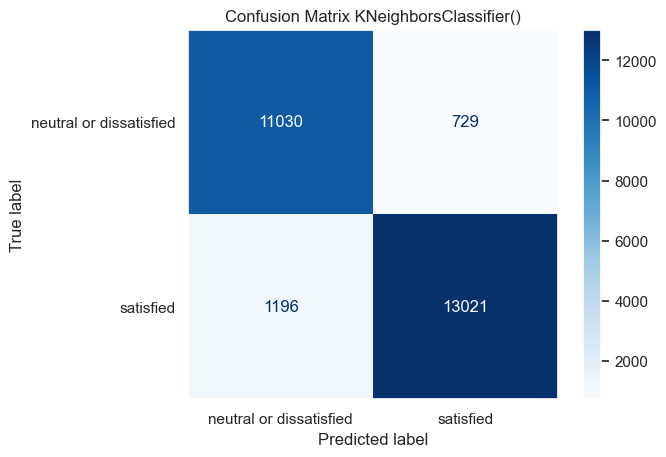

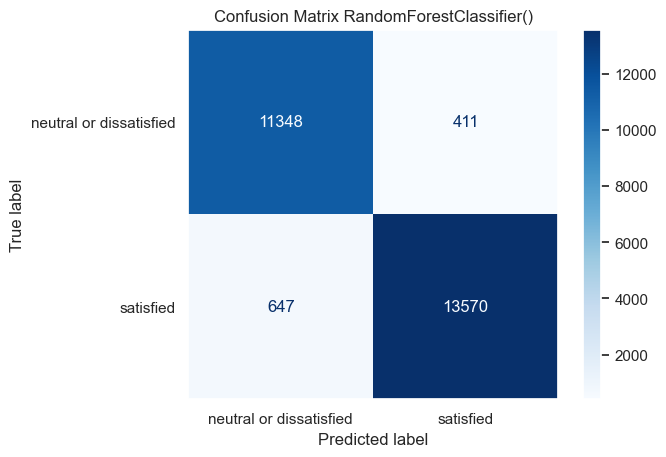

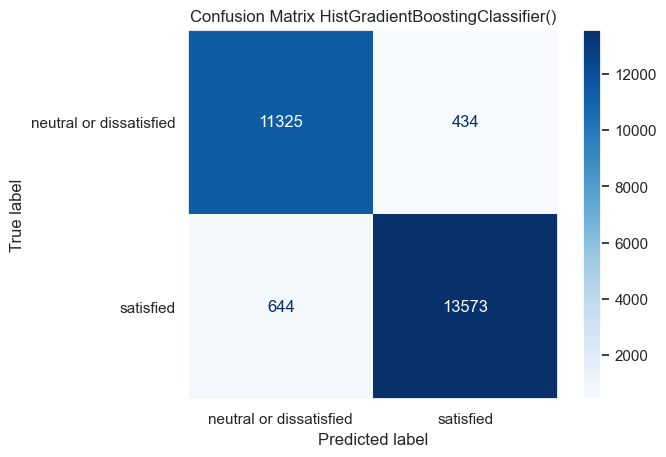

In [48]:
results = {}
all_clf = []
for classifier_name in classifiers.keys():
    classifier = globals()[classifier_name]()
    parameters = classifiers[classifier_name]
    res = getClassifResults(classifier, parameters, data=df)
    results[classifier_name] = res[0]
    all_clf.append(res[1])
    
    

c:\Users\tarik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\tarik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\tarik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\tarik\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_hist

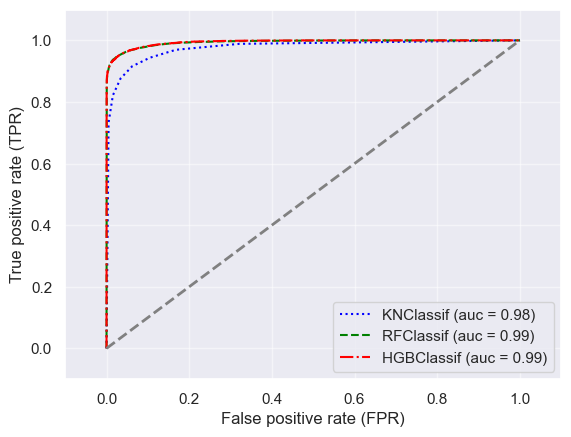

In [47]:
clf_labels = ['KNClassif', 'RFClassif', 'HGBClassif']
colors = ['blue', 'green', 'red']
linestyles = [':', '--', '-.', '-', 'solid', 'dashed']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    # assuming the label of the positive class is 1 ajout avec pos_label de la val qu'on associe à 1
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred, pos_label='satisfied')
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

### Benchmarking des modèles 

In [45]:
results_df = pd.DataFrame.from_dict({key: [val[i] for i in range(6)] for key, val in results.items()}, 
                                     orient='index',
                                     columns=['Testing time (sec)', 'Training score (F1-score)', 'Training score (accuracy stratKfold)', 'Evaluation score (F1-score)', 'Evaluation score (accuracy stratKfold)', 'Best parameters'])

In [46]:
results_df

,Testing time (sec),Training score (F1-score),Training score (accuracy stratKfold),Evaluation score (F1-score),Evaluation score (accuracy stratKfold),Best parameters
KNeighborsClassifier,8.5436,0.9230,0.9422,0.9263,0.9259,{'model__n_neighbors': 7}
RandomForestClassifier,80.9601,0.9581,1.0000,0.9594,0.9592,"{'model__criterion': 'entropy', 'model__n_esti..."
HistGradientBoostingClassifier,11.6931,0.9574,0.9659,0.9599,0.9598,"{'model__learning_rate': 0.2, 'model__loss': '..."


## 7.Recomandations

#### Je recommande le `HistGradientBoostingClassifier` il offre de meilleurs performance sur les deux métrics que sont l'accuracy et le F1 score de plus il est le second plus rapide des trois modèles testés